In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__data__ - first_set.xlsx, second_set.xlsx, third_set.xlsx merged. 

Three columns transformed to __(text, target)__ pairs, where __text__ - values of name, surname, patronymic and __target__ - corresponding label ('Ім’я' 'По батькові' 'Прізвище')

In [2]:
data = pd.read_csv('data/preprocessed.csv')
test = pd.read_csv('data/dev_data(dirty).csv')
data.dropna(inplace=True)

print(f'Data shape: {data.shape} \t Test shape: {test.shape} \n')
data.head()

Data shape: (358172, 2) 	 Test shape: (434664, 2) 



,text,target
0,Король,Прізвище
1,Король,Прізвище
2,Пащенко,Прізвище
3,Щоголева,Прізвище
4,Солоха,Прізвище


In [3]:
test['target'].value_counts()

По батькові    144888
Ім’я           144888
Прізвище       144888
Name: target, dtype: int64

In [4]:
data['target'].value_counts()

Прізвище       119417
Ім’я           119415
По батькові    119340
Name: target, dtype: int64

In [5]:
#test = test.drop_duplicates()
#data = data.drop_duplicates()
print(f'Data shape: {data.shape} \t Test shape: {test.shape} \n')

Data shape: (358172, 2) 	 Test shape: (434664, 2) 



In [6]:
test['target'].value_counts()

По батькові    144888
Ім’я           144888
Прізвище       144888
Name: target, dtype: int64

In [7]:
# train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], stratify=data['target'], random_state=42, train_size=0.9)
print(f'Train shape: {X_train.shape} \t Val shape: {X_val.shape} \n')

Train shape: (322354,) 	 Val shape: (35818,) 



# CountVectorizer

In [8]:
vectorizer_example = CountVectorizer(lowercase=True, ngram_range=(1, 2), analyzer='char')
example = ['Анатоліївна', 'Петрівна']
example_vectors = vectorizer_example.fit_transform(example).toarray()

In [9]:
example_df = pd.DataFrame(example_vectors, columns=vectorizer_example.get_feature_names())
example_df.insert(0, 'Text', example)
example_df.head()

,Text,а,ан,ат,в,вн,е,ет,л,лі,н,на,о,ол,п,пе,р,рі,т,то,тр,і,ів,ії,ї,їв
0,Анатоліївна,3,1,1,1,1,0,0,1,1,2,2,1,1,0,0,0,0,1,1,0,1,0,1,1,1
1,Петрівна,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,0,0


In [10]:
%%time
# text vectorization
vectorizer = CountVectorizer(
    encoding='utf-8', 
    lowercase=True, 
    ngram_range=(1, 3), 
    analyzer='char', 
    min_df=2, 
    max_features=120000
)
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test['text'].fillna(''))
print(f'Number of n-gram features: {X_train_vect.shape[1]}')

Number of n-gram features: 7512
CPU times: user 15 s, sys: 403 ms, total: 15.4 s
Wall time: 15.6 s


In [11]:
print(f'Number of n-gram features: {X_train_vect.shape[1]}')

Number of n-gram features: 7512


In [12]:
%%time
# text vectorization
vectorizer = CountVectorizer(
    encoding='utf-8', 
    lowercase=True, 
    ngram_range=(1, 3), 
    analyzer='char', 
    min_df=2, 
    max_features=120000
)
X_train_vect = vectorizer.fit_transform(data['text'])
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test['text'].fillna(''))
print(f'Number of n-gram features: {X_train_vect.shape[1]}')

Number of n-gram features: 7653
CPU times: user 14.7 s, sys: 359 ms, total: 15 s
Wall time: 15.1 s


In [13]:
from joblib import dump, load
#dump(vectorizer, 'text_vectorizer.joblib') 

In [14]:
vectorizer = load('model_weights/text_vectorizer.joblib') 
X_train_vect = vectorizer.transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test['text'].fillna(''))
print(f'Number of n-gram features: {X_train_vect.shape[1]}')

Number of n-gram features: 7653


In [15]:
y_train

2386         Прізвище
275991    По батькові
354020    По батькові
97489        Прізвище
57657        Прізвище
             ...     
187153           Ім’я
337376    По батькові
332580    По батькові
19485        Прізвище
241627    По батькові
Name: target, Length: 322354, dtype: object

In [16]:
encoder = {'Прізвище':0, 'По батькові': 2, 'Ім’я': 1}

In [17]:
y_train = y_train.apply(lambda x: encoder[x])
y_val = y_val.apply(lambda x: encoder[x])
y_test = test['target'].apply(lambda x: encoder[x])

## RandomForest model

In [18]:
%%time
# vanilla random forest
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train_vect, y_train)
val_preds = rf.predict(X_val_vect)
test_preds = rf.predict(X_test_vect)

CPU times: user 1min 32s, sys: 555 ms, total: 1min 32s
Wall time: 1min 33s


In [19]:
#dump(rf, 'vanilla_random_forest.joblib') 
rf = load('model_weights/vanilla_random_forest.joblib') 
val_preds = rf.predict(X_val_vect)
test_preds = rf.predict(X_test_vect)

In [20]:
val_preds

array([1, 0, 0, ..., 1, 0, 2])

Val confusion matrix


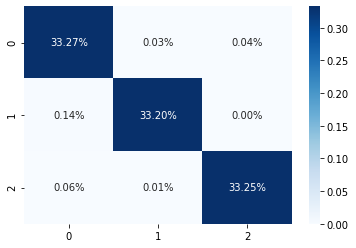

In [21]:
print('Val confusion matrix')
cf_matrix = confusion_matrix(y_val, val_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

Test confusion matrix


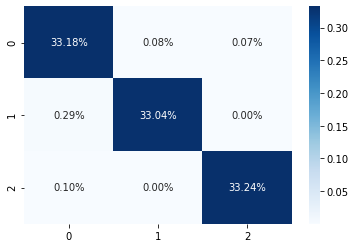

In [22]:
print('Test confusion matrix')
cf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [23]:
print(f"Val F1-micro : {f1_score(y_val, val_preds, average='micro')} \t F1-macro : {f1_score(y_val, val_preds, average='macro')}")
print(f"Test F1-micro : {f1_score(y_test, test_preds, average='micro')} \t F1-macro : {f1_score(y_test, test_preds, average='macro')}")

Val F1-micro : 0.9972639455022614 	 F1-macro : 0.9972652586555016
Test F1-micro : 0.9945774207203725 	 F1-macro : 0.9945806442844711


## Logistic Regression model

In [24]:
%%time
# vanilla log-reg
linreg = LogisticRegression(max_iter=1000)
linreg.fit(X_train_vect, y_train)
val_preds = linreg.predict(X_val_vect)
test_preds = linreg.predict(X_test_vect)

CPU times: user 4min 1s, sys: 39.5 s, total: 4min 41s
Wall time: 49.5 s


In [25]:
#dump(linreg, 'vanilla_linreg.joblib') 
linreg = load('model_weights/vanilla_linreg.joblib') 
val_preds = linreg.predict(X_val_vect)
test_preds = linreg.predict(X_test_vect)

Val confusion matrix


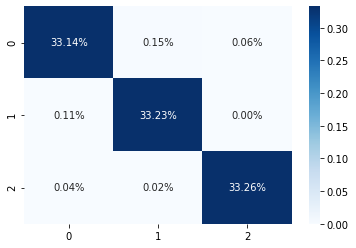

In [26]:
print('Val confusion matrix')
cf_matrix = confusion_matrix(y_val, val_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

Test confusion matrix


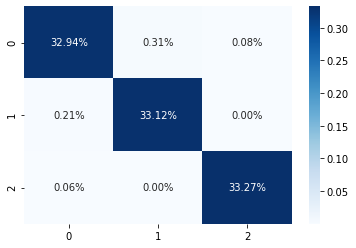

In [27]:
print('Test confusion matrix')
cf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [28]:
print(f"Val F1-micro : {f1_score(y_val, val_preds, average='micro')} \t F1-macro : {f1_score(y_val, val_preds, average='macro')}")
print(f"Test F1-micro : {f1_score(y_test, test_preds, average='micro')} \t F1-macro : {f1_score(y_test, test_preds, average='macro')}")

Val F1-micro : 0.9962588642581942 	 F1-macro : 0.9962589799510896
Test F1-micro : 0.9933787937349309 	 F1-macro : 0.9933770168934495


# Test

In [29]:
encoder = {0:'Прізвище', 2:'По батькові', 1:'Ім’я'}

In [30]:
%%time
sample = ['Король']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(encoder[np.argmax(sample_preds)])

[[0.99947517 0.00051889 0.00000595]]
Прізвище
CPU times: user 1.14 ms, sys: 164 µs, total: 1.3 ms
Wall time: 1.15 ms


In [31]:
%%time
sample = ['Тарас']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(encoder[np.argmax(sample_preds)])

[[0.12114572 0.87876047 0.00009381]]
Ім’я
CPU times: user 1.51 ms, sys: 826 µs, total: 2.33 ms
Wall time: 1.4 ms


In [32]:
%%time
sample = ['Богдан']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(encoder[np.argmax(sample_preds)])

[[0.11763823 0.88230426 0.00005752]]
Ім’я
CPU times: user 1.17 ms, sys: 499 µs, total: 1.67 ms
Wall time: 1.19 ms


In [33]:
%%time
sample = ['Анатоліївна']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(encoder[np.argmax(sample_preds)])

[[0.00000023 0.00002707 0.99997271]]
По батькові
CPU times: user 987 µs, sys: 555 µs, total: 1.54 ms
Wall time: 967 µs


In [34]:
%%time
sample = ['Солоха']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(encoder[np.argmax(sample_preds)])

[[0.99867826 0.00131277 0.00000897]]
Прізвище
CPU times: user 1.36 ms, sys: 321 µs, total: 1.68 ms
Wall time: 1.33 ms


In [35]:
sample = 'ШЕВЧЕНКО МИКОЛА ІВАНОВИЧ'.split(' ')
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
for i in sample_preds:
    print(encoder[np.argmax(i)], sample)

Прізвище ['ШЕВЧЕНКО', 'МИКОЛА', 'ІВАНОВИЧ']
Ім’я ['ШЕВЧЕНКО', 'МИКОЛА', 'ІВАНОВИЧ']
По батькові ['ШЕВЧЕНКО', 'МИКОЛА', 'ІВАНОВИЧ']


In [36]:
sample = 'БОЙКО ІВАН ВАСИЛЬОВИЧ'.split(' ')
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
for i in sample_preds:
    print(encoder[np.argmax(i)], sample)

Прізвище ['БОЙКО', 'ІВАН', 'ВАСИЛЬОВИЧ']
Ім’я ['БОЙКО', 'ІВАН', 'ВАСИЛЬОВИЧ']
По батькові ['БОЙКО', 'ІВАН', 'ВАСИЛЬОВИЧ']


In [37]:
sample = 'БОЙКО ІВАН ВАСИЛЬОВИЧ'.split(' ')
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
for i in sample_preds:
    print(encoder[np.argmax(i)], sample)

['БОЙКО' 'ІВАН' 'ВАСИЛЬОВИЧ']
Прізвище ['БОЙКО' 'ІВАН' 'ВАСИЛЬОВИЧ']
Ім’я ['БОЙКО' 'ІВАН' 'ВАСИЛЬОВИЧ']
По батькові ['БОЙКО' 'ІВАН' 'ВАСИЛЬОВИЧ']


In [38]:
sample = ['Джон']
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
for i in sample_preds:
    print(encoder[np.argmax(i)], sample)

['Джон']
Прізвище ['Джон']


In [39]:
sample = ['Вадома']
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
for i in sample_preds:
    print(encoder[np.argmax(i)], sample)

['Вадома']
Прізвище ['Вадома']


# Seq-2-Seq

In [40]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

In [41]:
data = pd.read_csv('data/final_dataset.csv')
data.shape

(119426, 3)

In [42]:
data.head()

,Прізвище,Ім’я,По батькові
0,Король,Тетяна,Олександрівна
1,Король,Сергій,Володимирович
2,Пащенко,Катерина,Михайлівна
3,Щоголева,Лідія,Степанівна
4,Солоха,Олег,Миколайович


In [43]:
def merge_rows(row):
    sample = f"({row['Прізвище']}, {['Прізвище']}) ({row['Ім’я']}, {['Ім’я']}) ({row['По батькові']}, {['По батькові']})"
    return sample

In [44]:
data['seq_text'] = data.progress_apply(lambda x: merge_rows(x), axis=1)

In [45]:
data['seq_text'].loc[1]

"(Король, ['Прізвище']) (Сергій, ['Ім’я']) (Володимирович, ['По батькові'])"